In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/anchor_final.zip -d /content/
!unzip /content/drive/MyDrive/train.zip -d /content/

Archive:  /content/drive/MyDrive/anchor_final.zip
   creating: /content/anchor_final/
  inflating: /content/__MACOSX/._anchor_final  
  inflating: /content/anchor_final/4133_p_g_1281.jpg  
  inflating: /content/__MACOSX/anchor_final/._4133_p_g_1281.jpg  
  inflating: /content/anchor_final/8140_p_g_171.jpg  
  inflating: /content/__MACOSX/anchor_final/._8140_p_g_171.jpg  
  inflating: /content/anchor_final/2656_p_g_1191.jpg  
  inflating: /content/__MACOSX/anchor_final/._2656_p_g_1191.jpg  
  inflating: /content/anchor_final/644_p_g_313.jpg  
  inflating: /content/__MACOSX/anchor_final/._644_p_g_313.jpg  
  inflating: /content/anchor_final/11469_p_g_124_b.jpg  
  inflating: /content/__MACOSX/anchor_final/._11469_p_g_124_b.jpg  
  inflating: /content/anchor_final/77_p_g_1278.jpg  
  inflating: /content/__MACOSX/anchor_final/._77_p_g_1278.jpg  
  inflating: /content/anchor_final/14926_p_g_512.jpg  
  inflating: /content/__MACOSX/anchor_final/._14926_p_g_512.jpg  
  inflating: /content/anc

In [ ]:
!unzip /content/drive/MyDrive/anchor_images.zip -d /content/

Archive:  /content/drive/MyDrive/anchor_images.zip
   creating: /content/anchor_images/
  inflating: /content/anchor_images/19319_p_g_146.jpg  
  inflating: /content/__MACOSX/anchor_images/._19319_p_g_146.jpg  
  inflating: /content/anchor_images/21118_p_g_1207.jpg  
  inflating: /content/__MACOSX/anchor_images/._21118_p_g_1207.jpg  
  inflating: /content/anchor_images/44618_p_g_4877.jpg  
  inflating: /content/__MACOSX/anchor_images/._44618_p_g_4877.jpg  
  inflating: /content/anchor_images/80106_p_g_33.jpg  
  inflating: /content/__MACOSX/anchor_images/._80106_p_g_33.jpg  
  inflating: /content/anchor_images/832297_p_kopt_108.jpg  
  inflating: /content/__MACOSX/anchor_images/._832297_p_kopt_108.jpg  
  inflating: /content/anchor_images/4133_p_g_1281.jpg  
  inflating: /content/__MACOSX/anchor_images/._4133_p_g_1281.jpg  
  inflating: /content/anchor_images/8140_p_g_171.jpg  
  inflating: /content/__MACOSX/anchor_images/._8140_p_g_171.jpg  
  inflating: /content/anchor_images/89297_p

In [ ]:
!unzip /content/drive/MyDrive/test.zip -d /content/

Archive:  /content/drive/MyDrive/test.zip
replace /content/__MACOSX/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#0)  Load an Image


Grid image saved at: /content/saved_grid_image.jpg


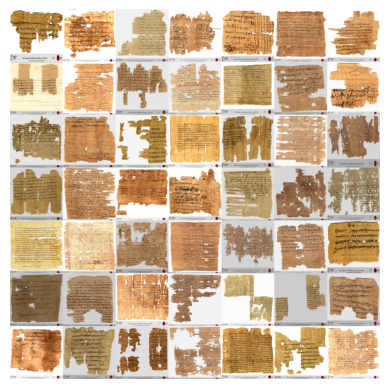

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Define the transformations including ColorJitter for brightness and contrast
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=(0.80, 1.20), contrast=(0.80, 1.20), saturation=0, hue=0),
    transforms.ToTensor()
])

# Function to load, transform, and return a PIL image
def load_and_transform_image(image_path):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply the transform
    transformed_image = transform(image)

    # Convert the tensor back to a PIL image
    pil_image = transforms.ToPILImage()(transformed_image)

    return pil_image

# Plot a 7x7 grid of images and save it as a single image
def plot_image_grid(image_dir, save_path, num_images=49):
    # Grid dimensions
    grid_size = 7
    image_size = 224  # Size of each image (224x224 after resizing)

    # Create a blank canvas for the 7x7 grid
    grid_image = Image.new('RGB', (grid_size * image_size, grid_size * image_size))

    # Get the list of .jpg image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')][:num_images]  # Filter only .jpg files

    for i, image_file in enumerate(image_files):
        # Load and transform the image
        image_path = os.path.join(image_dir, image_file)
        transformed_image = load_and_transform_image(image_path)

        # Calculate the position in the grid (row, col)
        row = i // grid_size
        col = i % grid_size

        # Paste the transformed image into the grid at the calculated position
        grid_image.paste(transformed_image, (col * image_size, row * image_size))

    # Save the grid image to the specified path
    grid_image.save(save_path)
    print(f"Grid image saved at: {save_path}")

    # Display the grid of images
    plt.imshow(grid_image)
    plt.axis('off')  # Hide the axes for a cleaner look
    plt.show()

# Example: Directory containing your images and save path
image_dir = '/content/anchor_final/'  # Update this with your actual directory path
save_path = '/content/saved_grid_image.jpg'  # Path to save the grid image
plot_image_grid(image_dir, save_path)


#1) DATALOADER

In [ ]:
#new
import os
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch


# Example of data augmentation and normalization transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip image with a probability of 0.5
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, etc.
    #transforms.RandomRotation(10),  # Randomly rotate image within 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

class SiameseDataset(Dataset):
    def __init__(self, anchor_dir, train_dir, transform=None):
        self.anchor_dir = anchor_dir
        self.train_dir = train_dir
        self.transform = transform
        self.anchor_images = []
        self.positive_images = {}
        self.valid_image_extensions = ('.jpg', '.jpeg', '.png')

        # Load anchor images
        for img_name in os.listdir(anchor_dir):
            img_path = os.path.join(anchor_dir, img_name)
            if os.path.isfile(img_path) and img_name.lower().endswith(self.valid_image_extensions):
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify that this is an image file
                    class_name = os.path.splitext(img_name)[0]
                    self.anchor_images.append((class_name, img_path))
                except (IOError, SyntaxError):
                    print(f"File {img_path} is not a valid image.")

        # Load positive images
        for class_name in os.listdir(train_dir):
            class_path = os.path.join(train_dir, class_name)
            if os.path.isdir(class_path):
                self.positive_images[class_name] = []
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    if os.path.isfile(img_path) and img_name.lower().endswith(self.valid_image_extensions):
                        try:
                            with Image.open(img_path) as img:
                                img.verify()  # Verify that this is an image file
                            self.positive_images[class_name].append(img_path)
                        except (IOError, SyntaxError):
                            print(f"File {img_path} is not a valid image.")

    def __len__(self):
        return len(self.anchor_images)

    def load_image(self, img_path):
        img = Image.open(img_path).convert("RGB")
        return img

    def __getitem__(self, index):
        anchor_class, anchor_path = self.anchor_images[index]

        # Load anchor image
        anchor_img = self.load_image(anchor_path)
        if self.transform:
            anchor_img = self.transform(anchor_img)

        # Get a positive image
        positive_path = random.choice(self.positive_images[anchor_class])
        positive_img = self.load_image(positive_path)
        if self.transform:
            positive_img = self.transform(positive_img)

        # Get a negative image (from a different class)
        negative_class = random.choice(list(self.positive_images.keys()))
        while negative_class == anchor_class:
            negative_class = random.choice(list(self.positive_images.keys()))
        negative_img = self.load_image(random.choice(self.positive_images[negative_class]))
        if self.transform:
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

anchor_dir = "/content/anchor_final"
train_dir = "/content/train/"

dataset = SiameseDataset(anchor_dir=anchor_dir, train_dir=train_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


#2) Network Architecture

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pretrained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Freeze layers
'''
for name, param in resnet18.named_parameters():
    if 'layer4.1' not in name:  # Freeze up to layer3
        param.requires_grad = False

for param in resnet18.fc.parameters():
    param.requires_grad = True
'''
freeze_up_to_idx = 57

# Freeze layers up to freeze_up_to_idx
for idx, (name, param) in enumerate(resnet18.named_parameters()):
    if idx < freeze_up_to_idx:
        param.requires_grad = False
    else:
        param.requires_grad = True  # Unfreeze layers beyond freeze_up_to_idx

# Modify the fully connected layer to output 128 dimension embedding
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 128)



# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model

    def forward_one(self, x):
        return self.base_model(x)

    def forward(self, input1, input2=None):
        if input2 is None:
            # Handle the case where only one input is provided
            embedding = self.forward_one(input1)
            return F.normalize(embedding, p=2, dim=1)  # Normalize the embedding
        else:
            # Handle the case where two inputs are provided
            embedding1 = self.forward_one(input1)
            embedding2 = self.forward_one(input2)
            return F.normalize(embedding1, p=2, dim=1), F.normalize(embedding2, p=2, dim=1)


# Initialize the Siamese Network with the modified ResNet-50
model = SiameseNetwork(resnet18)


In [ ]:
# Count and print the number of frozen and trainable parameters
num_frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of frozen parameters: {num_frozen_params}")
print(f"Number of trainable parameters: {num_trainable_params}")

# Print the modified ResNet-18 architecture with information about frozen and trainable layers
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"Layer: {name}, Status: {status}, Shape: {param.shape}")

Number of frozen parameters: 8816192
Number of trainable parameters: 2425984
Layer: base_model.conv1.weight, Status: Frozen, Shape: torch.Size([64, 3, 7, 7])
Layer: base_model.bn1.weight, Status: Frozen, Shape: torch.Size([64])
Layer: base_model.bn1.bias, Status: Frozen, Shape: torch.Size([64])
Layer: base_model.layer1.0.conv1.weight, Status: Frozen, Shape: torch.Size([64, 64, 3, 3])
Layer: base_model.layer1.0.bn1.weight, Status: Frozen, Shape: torch.Size([64])
Layer: base_model.layer1.0.bn1.bias, Status: Frozen, Shape: torch.Size([64])
Layer: base_model.layer1.0.conv2.weight, Status: Frozen, Shape: torch.Size([64, 64, 3, 3])
Layer: base_model.layer1.0.bn2.weight, Status: Frozen, Shape: torch.Size([64])
Layer: base_model.layer1.0.bn2.bias, Status: Frozen, Shape: torch.Size([64])
Layer: base_model.layer1.1.conv1.weight, Status: Frozen, Shape: torch.Size([64, 64, 3, 3])
Layer: base_model.layer1.1.bn1.weight, Status: Frozen, Shape: torch.Size([64])
Layer: base_model.layer1.1.bn1.bias, Sta

In [ ]:
print(" ResNet-18 architecture:\n", resnet18)



 ResNet-18 architecture:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re

In [ ]:
import torch.nn.functional as F
from torchsummary import summary
summary(model, [(3, 224, 224),(3,224,224)])  # Assuming input size is 224x224 and 3 channels (RGB)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#3) Loss Function

In [ ]:
import torch.nn.functional as F

def triplet_loss(anchor, positive, negative, margin=0.8):
    # Compute distances
    d_p = F.pairwise_distance(anchor, positive, p=2)
    print(f'd_p: {d_p}')
    d_n = F.pairwise_distance(anchor, negative, p=2)
    print(f'd_n: {d_n}')
    # Compute loss
    loss = torch.clamp(d_p - d_n + margin, min=0.0).mean()

    return loss


#3.2) TRAINING LOOP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

checkpoint_path = '/content/resnet18_checkpoint_RUN10.pth'  # Path to save/load checkpoint

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Loaded checkpoint '{checkpoint_path}' (epoch {start_epoch})")
else:
    start_epoch = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0

    for i, (anchor_img, positive_img, negative_img) in enumerate(dataloader):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        optimizer.zero_grad()

        # Forward pass
        anchor_out, positive_out = model(anchor_img, positive_img)
        negative_out = model(negative_img)
        # Compute loss
        loss = triplet_loss(anchor_out, positive_out, negative_out)
        print(loss.item())
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 3 == 0:    # Print every 3 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {running_loss / 3:.4f}', flush=True)
            running_loss = 0.0

    # Print average loss for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Epoch Loss: {epoch_loss / len(dataloader):.4f}')
    # Save checkpoint after 50 epochs
    if epoch >= 49:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_path)

print("Finished Training")


#4) Load Model After Training

In [ ]:
import torch.nn.functional as F
import torch
from torchvision import transforms
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define the model again (same as when you trained it)
resnet18 = models.resnet18(pretrained=False)  # Do not load pretrained weights here
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 128)  # Modified final layer

# Initialize the Siamese network
model = SiameseNetwork(base_model=resnet18)

# Load the checkpoint (replace 'path/to/checkpoint.pth' with your actual path)
checkpoint = torch.load('/content/resnet18_checkpoint_RUN10.pth', map_location=device)  # Use 'cuda' if you have GPU

# Load the model state from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

# Example transform, similar to training setup
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Load the images you want to compute embeddings for
image1 = load_image('/content/anchor_images/4133_p_g_1281.jpg')
image2 = load_image('/content/test/4133_p_g_1281/4133_p_g_1281_11.jpg')

# Inference with SiameseNetwork model to compute embeddings
with torch.no_grad():
    embedding1, embedding2 = model(image1, image2)

# Check the embeddings
#print(f"Embedding 1: {embedding1}")
#print(f"Embedding 2: {embedding2}")

# Calculate cosine similarity
def cosine_similarity(embedding1, embedding2):
    # Compute cosine similarity
    cos_sim = F.cosine_similarity(embedding1, embedding2)
    return cos_sim.item()  # Convert to a scalar

# Call the cosine similarity function
similarity = cosine_similarity(embedding1, embedding2)

# Print the cosine similarity
print(f"Cosine Similarity: {similarity:.4f}")

#5) VALIDATION

In [ ]:
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model again
resnet18 = models.resnet18(pretrained=False)  # Do not load pretrained weights here
num_ftrs = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_ftrs, 128)  # Modified final layer

# Initialize the Siamese network
model = SiameseNetwork(base_model=resnet18)

# Load the checkpoint (replace 'path/to/checkpoint.pth' with your actual path)
checkpoint = torch.load('/content/resnet18_checkpoint_RUN10.pth', map_location=device)

# Load the model state from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to GPU if available
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    return image

# Save embeddings for all anchor images
def save_anchor_embeddings(anchor_folder_path):
    embeddings = []  # To store the embeddings and filenames
    filenames = []   # To store the corresponding filenames

    # Iterate through all image files in the anchor folder
    image_files = [f for f in os.listdir(anchor_folder_path) if f.endswith(('jpg', 'png'))]

    with torch.no_grad():
        for image_file in image_files:
            image_path = os.path.join(anchor_folder_path, image_file)
            try:
                image = load_image(image_path)
                embedding = model(image)

                # Save embedding as a numpy array
                embeddings.append(embedding.squeeze(0).cpu().numpy())

                # Save the image path
                filenames.append(image_path)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    # Check if we have any embeddings before saving
    if embeddings:
        # Convert embeddings list to a numpy array
        embeddings_np = np.vstack(embeddings)  # Shape (num_images, 128)

        # Save embeddings and filenames to files
        np.save('embeddings.npy', embeddings_np)
        with open('filenames.txt', 'w') as f:
            for filename in filenames:
                f.write(f"{filename}\n")

        print(f"Saved {len(embeddings)} embeddings and filenames.")
    else:
        print("No embeddings to save.")

# Call the function to save embeddings of anchor images
anchor_folder_path = '/content/anchor_images'  # Path to the anchor images folder
save_anchor_embeddings(anchor_folder_path)

def get_base_name(file_name, is_anchor=False):

    if is_anchor:
        # For anchor images: strip the file extension
        return os.path.splitext(file_name)[0]
    else:
        # For query images: return the part before the last underscore
        return '_'.join(file_name.split('_')[:-1])

# Function to check if the anchor image matches the query image
def check_match(anchor_filename, query_filename):
    query_base = get_base_name(query_filename,is_anchor=False)
    anchor_base= get_base_name(anchor_filename, is_anchor=True )
    return anchor_base == query_base

# Function to find the closest K images given a query image and check if anchor image is in top K
def evaluate_top_k(query_image_path, top_k=3):
    # Load the query image and compute its embedding
    query_image = load_image(query_image_path)

    with torch.no_grad():
        query_embedding = model(query_image).squeeze(0).to(device)  # Query embedding on GPU

    # Load saved embeddings and move them to the GPU
    saved_embeddings = torch.tensor(np.load('embeddings.npy')).to(device)

    with open('filenames.txt', 'r') as f:
        saved_filenames = f.readlines()

    # Compute cosine similarity between query embedding and all saved embeddings
    similarities = F.cosine_similarity(query_embedding, saved_embeddings, dim=-1)

    # Get indices of top_k most similar images
    top_k_indices = torch.topk(similarities, top_k).indices.tolist()

    # Check if the anchor image is in the top K similar images
    correct_anchor = False
    for idx in top_k_indices:
        anchor_filename = os.path.basename(saved_filenames[idx].strip())
        query_filename = os.path.basename(query_image_path)

        if check_match(anchor_filename, query_filename):
            correct_anchor = True
            break

    return correct_anchor

# Iterate through all query images in the test folder
def evaluate_all_queries(test_folder_path, top_k=3):
    correct = 0
    total = 0

    # Iterate through all subfolders and query images
    for root, dirs, files in os.walk(test_folder_path):
        for file in files:
            if file.endswith(('jpg', 'png')):
                query_image_path = os.path.join(root, file)
                total += 1

                # Evaluate the top K results for the current query image
                if evaluate_top_k(query_image_path, top_k=top_k):
                    correct += 1
                else:
                    print(f"Wrong for query: {query_image_path}")

    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"Accuracy: {accuracy:.2f}% ({correct}/{total} correct)")

# Example usage: Evaluate all queries in the test folder
test_folder_path = '/content/test/'  # Path to the test folder with subfolders
evaluate_all_queries(test_folder_path, top_k=1)



In [ ]:
# Function to find the closest K images given a query image and check if anchor image is in top K
def evaluate_top_k(query_image_path, top_k=3):
    # Load the query image and compute its embedding
    query_image = load_image(query_image_path)

    with torch.no_grad():
        query_embedding = model(query_image).squeeze(0).to(device)  # Query embedding on GPU

    # Load saved embeddings and move them to the GPU
    saved_embeddings = torch.tensor(np.load('embeddings.npy')).to(device)

    with open('filenames.txt', 'r') as f:
        saved_filenames = f.readlines()

    # Compute cosine similarity between query embedding and all saved embeddings
    similarities = F.cosine_similarity(query_embedding, saved_embeddings, dim=-1)

    # Get indices of top_k most similar images
    top_k_indices = torch.topk(similarities, top_k).indices.tolist()

    # Print the query image name
    print(f"\nQuery Image: {os.path.basename(query_image_path)}")

    # Store the information of top K similar anchor images
    top_k_anchors = []
    for idx in top_k_indices:
        anchor_filename = os.path.basename(saved_filenames[idx].strip())
        similarity = similarities[idx].item()
        top_k_anchors.append((anchor_filename, similarity))
        print(f"Top {len(top_k_anchors)} Similar Anchor: {anchor_filename}, Similarity: {similarity:.4f}")

    # Check if the correct anchor image is in the top K similar images
    correct_anchor = False
    for anchor_filename, _ in top_k_anchors:
        if check_match(anchor_filename, os.path.basename(query_image_path)):
            correct_anchor = True
            break

    return correct_anchor

# Iterate through all query images in the test folder
def evaluate_all_queries(test_folder_path, top_k=3):
    correct = 0
    total = 0

    # Iterate through all subfolders and query images
    for root, dirs, files in os.walk(test_folder_path):
        for file in files:
            if file.endswith(('jpg', 'png')):
                query_image_path = os.path.join(root, file)
                total += 1

                # Evaluate the top K results for the current query image
                if evaluate_top_k(query_image_path, top_k=top_k):
                    correct += 1
                else:
                    print(f"Wrong for query: {query_image_path}")

    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"\nAccuracy: {accuracy:.2f}% ({correct}/{total} correct)")

# Example usage: Evaluate all queries in the test folder
test_folder_path = '/content/test/'  # Path to the test folder with subfolders
evaluate_all_queries(test_folder_path, top_k=1)


In [ ]:
import matplotlib.pyplot as plt

# Function to plot the query image and top K similar anchor images
def plot_query_and_top_k(query_image_path, top_k_anchors):
    fig, axes = plt.subplots(1, len(top_k_anchors) + 1, figsize=(15, 5))

    # Plot the query image
    query_image = Image.open(query_image_path).convert('RGB')
    axes[0].imshow(query_image)
    axes[0].set_title(f"Query Image")
    axes[0].axis('off')  # Hide axes

    # Plot the top K anchor images
    for i, (anchor_filename, similarity) in enumerate(top_k_anchors):
        anchor_image = Image.open(anchor_filename).convert('RGB')
        axes[i + 1].imshow(anchor_image)
        axes[i + 1].set_title(f"Anchor {i+1}\nSim: {similarity:.4f}")
        axes[i + 1].axis('off')  # Hide axes

    # Display the plot
    plt.tight_layout()
    plt.show()

# Function to find the closest K images given a query image and check if anchor image is in top K
def evaluate_top_k(query_image_path, top_k=3):
    # Load the query image and compute its embedding
    query_image = load_image(query_image_path)

    with torch.no_grad():
        query_embedding = model(query_image).squeeze(0).to(device)  # Query embedding on GPU

    # Load saved embeddings and move them to the GPU
    saved_embeddings = torch.tensor(np.load('embeddings.npy')).to(device)

    with open('filenames.txt', 'r') as f:
        saved_filenames = f.readlines()

    # Compute cosine similarity between query embedding and all saved embeddings
    similarities = F.cosine_similarity(query_embedding, saved_embeddings, dim=-1)

    # Get indices of top_k most similar images
    top_k_indices = torch.topk(similarities, top_k).indices.tolist()

    # Print the query image name
    print(f"\nQuery Image: {os.path.basename(query_image_path)}")

    # Store the information of top K similar anchor images
    top_k_anchors = []
    for idx in top_k_indices:
        anchor_filename = saved_filenames[idx].strip()
        similarity = similarities[idx].item()
        top_k_anchors.append((anchor_filename, similarity))
        print(f"Top {len(top_k_anchors)} Similar Anchor: {os.path.basename(anchor_filename)}, Similarity: {similarity:.4f}")

    # Plot the query image and top K anchor images
    plot_query_and_top_k(query_image_path, top_k_anchors)

    # Check if the correct anchor image is in the top K similar images
    correct_anchor = False
    for anchor_filename, _ in top_k_anchors:
        if check_match(os.path.basename(anchor_filename), os.path.basename(query_image_path)):
            correct_anchor = True
            break

    return correct_anchor

# Iterate through all query images in the test folder
def evaluate_all_queries(test_folder_path, top_k=3):
    correct = 0
    total = 0

    # Iterate through all subfolders and query images
    for root, dirs, files in os.walk(test_folder_path):
        for file in files:
            if file.endswith(('jpg', 'png')):
                query_image_path = os.path.join(root, file)
                total += 1

                # Evaluate the top K results for the current query image
                if evaluate_top_k(query_image_path, top_k=top_k):
                    correct += 1
                else:
                    print(f"Wrong for query: {query_image_path}")

    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"\nAccuracy: {accuracy:.2f}% ({correct}/{total} correct)")

# Example usage: Evaluate all queries in the test folder
test_folder_path = '/content/test/'  # Path to the test folder with subfolders
evaluate_all_queries(test_folder_path, top_k=3)
